In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [23]:
X_digits, y_digits = load_digits(return_X_y=True)
data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = y_digits

sample_size = 300

In [8]:
print(data)

[[ 0.         -0.33501649 -0.04308102 ... -1.14664746 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  0.54856067 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  1.56568555  1.6951369
  -0.19600752]
 ...
 [ 0.         -0.33501649 -0.88456568 ... -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.67419451 ...  0.8876023  -0.5056698
  -0.19600752]
 [ 0.         -0.33501649  1.00877481 ...  0.8876023  -0.26113572
  -0.19600752]]


In [22]:
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [4]:
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


In [5]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [6]:
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is 

k-means++	0.66s	69504	0.609	0.655	0.631	0.481	0.627	0.135
random   	0.24s	69519	0.598	0.645	0.621	0.467	0.617	0.168


In [21]:
print(" >> n_digits = ", n_digits)

 >> n_digits =  10


In [ ]:
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

In [14]:
print(" >> n_digits = ", n_digits)

 >> n_digits =  10


In [15]:
# #############################################################################
# Visualize the results on PCA-reduced data

'''
K-means++ paper: 
Arthur D, Vassilvitskii S. k-means++: The advantages of careful seeding. 
InProceedings of the eighteenth annual ACM-SIAM symposium 
on Discrete algorithms 2007 Jan 7 (pp. 1027-1035). Society for Industrial and 
Applied Mathematics.

Explanation: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
e.g.: 
Say we need to select 2 cluster centers, instead of selecting them all randomly 
{like we do in simple k means}, we will select the first one randomly, then find the 
points that are farthest to the first center{These points most probably do not belong to 
the first cluster center as they are far from it} and assign the second cluster center 
nearby those far points.
'''

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
# kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=3)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

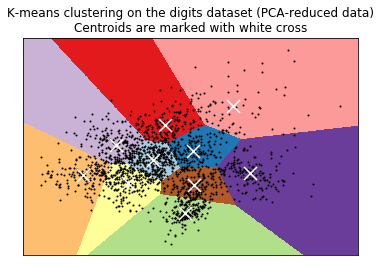

In [13]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [28]:
# Source: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb#scrollTo=jgwZgNI36fk0
y_kmeans = kmeans.predict(reduced_data)

accuracy = np.sum(y_kmeans == y_digits).astype(float) / len(y_digits)

print(" >> reduced_data = ", reduced_data.shape)
print(" >> y_kmeans = ", y_kmeans)
print(" >> y_digits = ", y_digits)
print(" >> accuracy = ", accuracy)

 >> reduced_data =  (1797, 2)
 >> y_kmeans =  [1 3 1 ... 1 1 7]
 >> y_digits =  [0 1 2 ... 8 9 8]
 >> accuracy =  0.16805787423483584
